In [ ]:
#Task 2.2: Improving Cuisine Maps


In [94]:
import math
import json
import pickle
import random
import logging
import glob
import argparse
import os
import warnings
import pandas as pd
import numpy as np
from gensim import models
from gensim import matutils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from time import time
from nltk.tokenize import sent_tokenize
from pathlib2 import Path
from nltk.corpus import stopwords
from collections import Counter, OrderedDict
STOP_WORDS = stopwords.words('english')
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cluster_colors = {-1:'black', 0:'gold', 1:'blue', 2:'green', 3:'red', 4:'saddlebrown', 5:'darkviolet', 
            6:'yellow', 7:'pink', 8:'orange', 9:'firebrick', 10:'deepskyblue',
            11:'aqua', 12:'saddlebrown', 13:'springgreen', 14:'dodgerblue', 15:'coral',
            16:'mediumslateblue', 17:'magenta', 18:'seagreen', 19:'lightslategrey', 20:'cyan'}
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [95]:
%%time
import os
from pathlib import Path
from collections import Counter, OrderedDict

N = 50
#allfiles = os.listdir("C:\\Projects\\CapstoneCS598\\Task2\\Categories")
allfiles = os.listdir("C:\\Categories")



review_counter = {}

for f in allfiles:
    cuisine = f
    with open(Path("C:\\Categories", f), 'r', encoding='utf-8') as file:
        count = len(file.readlines())
    review_counter.update({cuisine: count})

review_counter = Counter(review_counter)
topN_cuisines = list(OrderedDict(review_counter.most_common(N)).keys())

CPU times: total: 1.36 s
Wall time: 2.79 s


In [96]:
%%time
import os
from pathlib import Path

# Define the directory containing the text files
directory = "C:\\Categories"

# Get the list of all files in the directory
allfiles = os.listdir(directory)

# Process each file in the list
cuisines = [f.replace('.txt', '') for f in allfiles]
contents = []
for f in allfiles:
    # Construct the full path to the file
    file_path = os.path.join(directory, f)
    # Read the contents of the file
    content = Path(file_path).read_text(encoding="utf8").replace('\n', ' ')
    contents.append(content)

CPU times: total: 3.22 s
Wall time: 3.91 s


In [97]:
def vectorizer(contents, use_idf=False, min_df=2, max_df=0.5, stop_words=None):
    vectorizer = TfidfVectorizer(stop_words=stop_words,
                                 encoding='utf-8',
                                 strip_accents='unicode',
                                 lowercase=True,
                                 use_idf=use_idf,
                                 max_features=10000,
                                 min_df=min_df,
                                 max_df=max_df)
    matrix = vectorizer.fit_transform(contents)
    
    id2words = {i: word for i, word in enumerate(vectorizer.get_feature_names_out())}
    
    return matrix, np.vstack([cosine_similarity(val, matrix) for val in matrix]), id2words

In [98]:
def draw(matrix, colormap='BuPu'):
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap=colormap)
    ax.set_xticks(np.arange(matrix.shape[1]), minor=False)
    ax.set_yticks(np.arange(matrix.shape[0]), minor=False)
    ax.grid(which='major', color='blue', linestyle='-', linewidth='0.3')
    ax.set_xticklabels(matrix.index, rotation='vertical')
    ax.set_yticklabels(matrix.index)
    fig.colorbar(cax, ticks=np.linspace(0,1,11))
    fig.set_size_inches(20, 20)
    plt.show()

In [99]:
%%time
matrix_if1, similarity_if1, id2words1 = vectorizer(contents, use_idf=False)

CPU times: total: 2min 19s
Wall time: 2min 29s


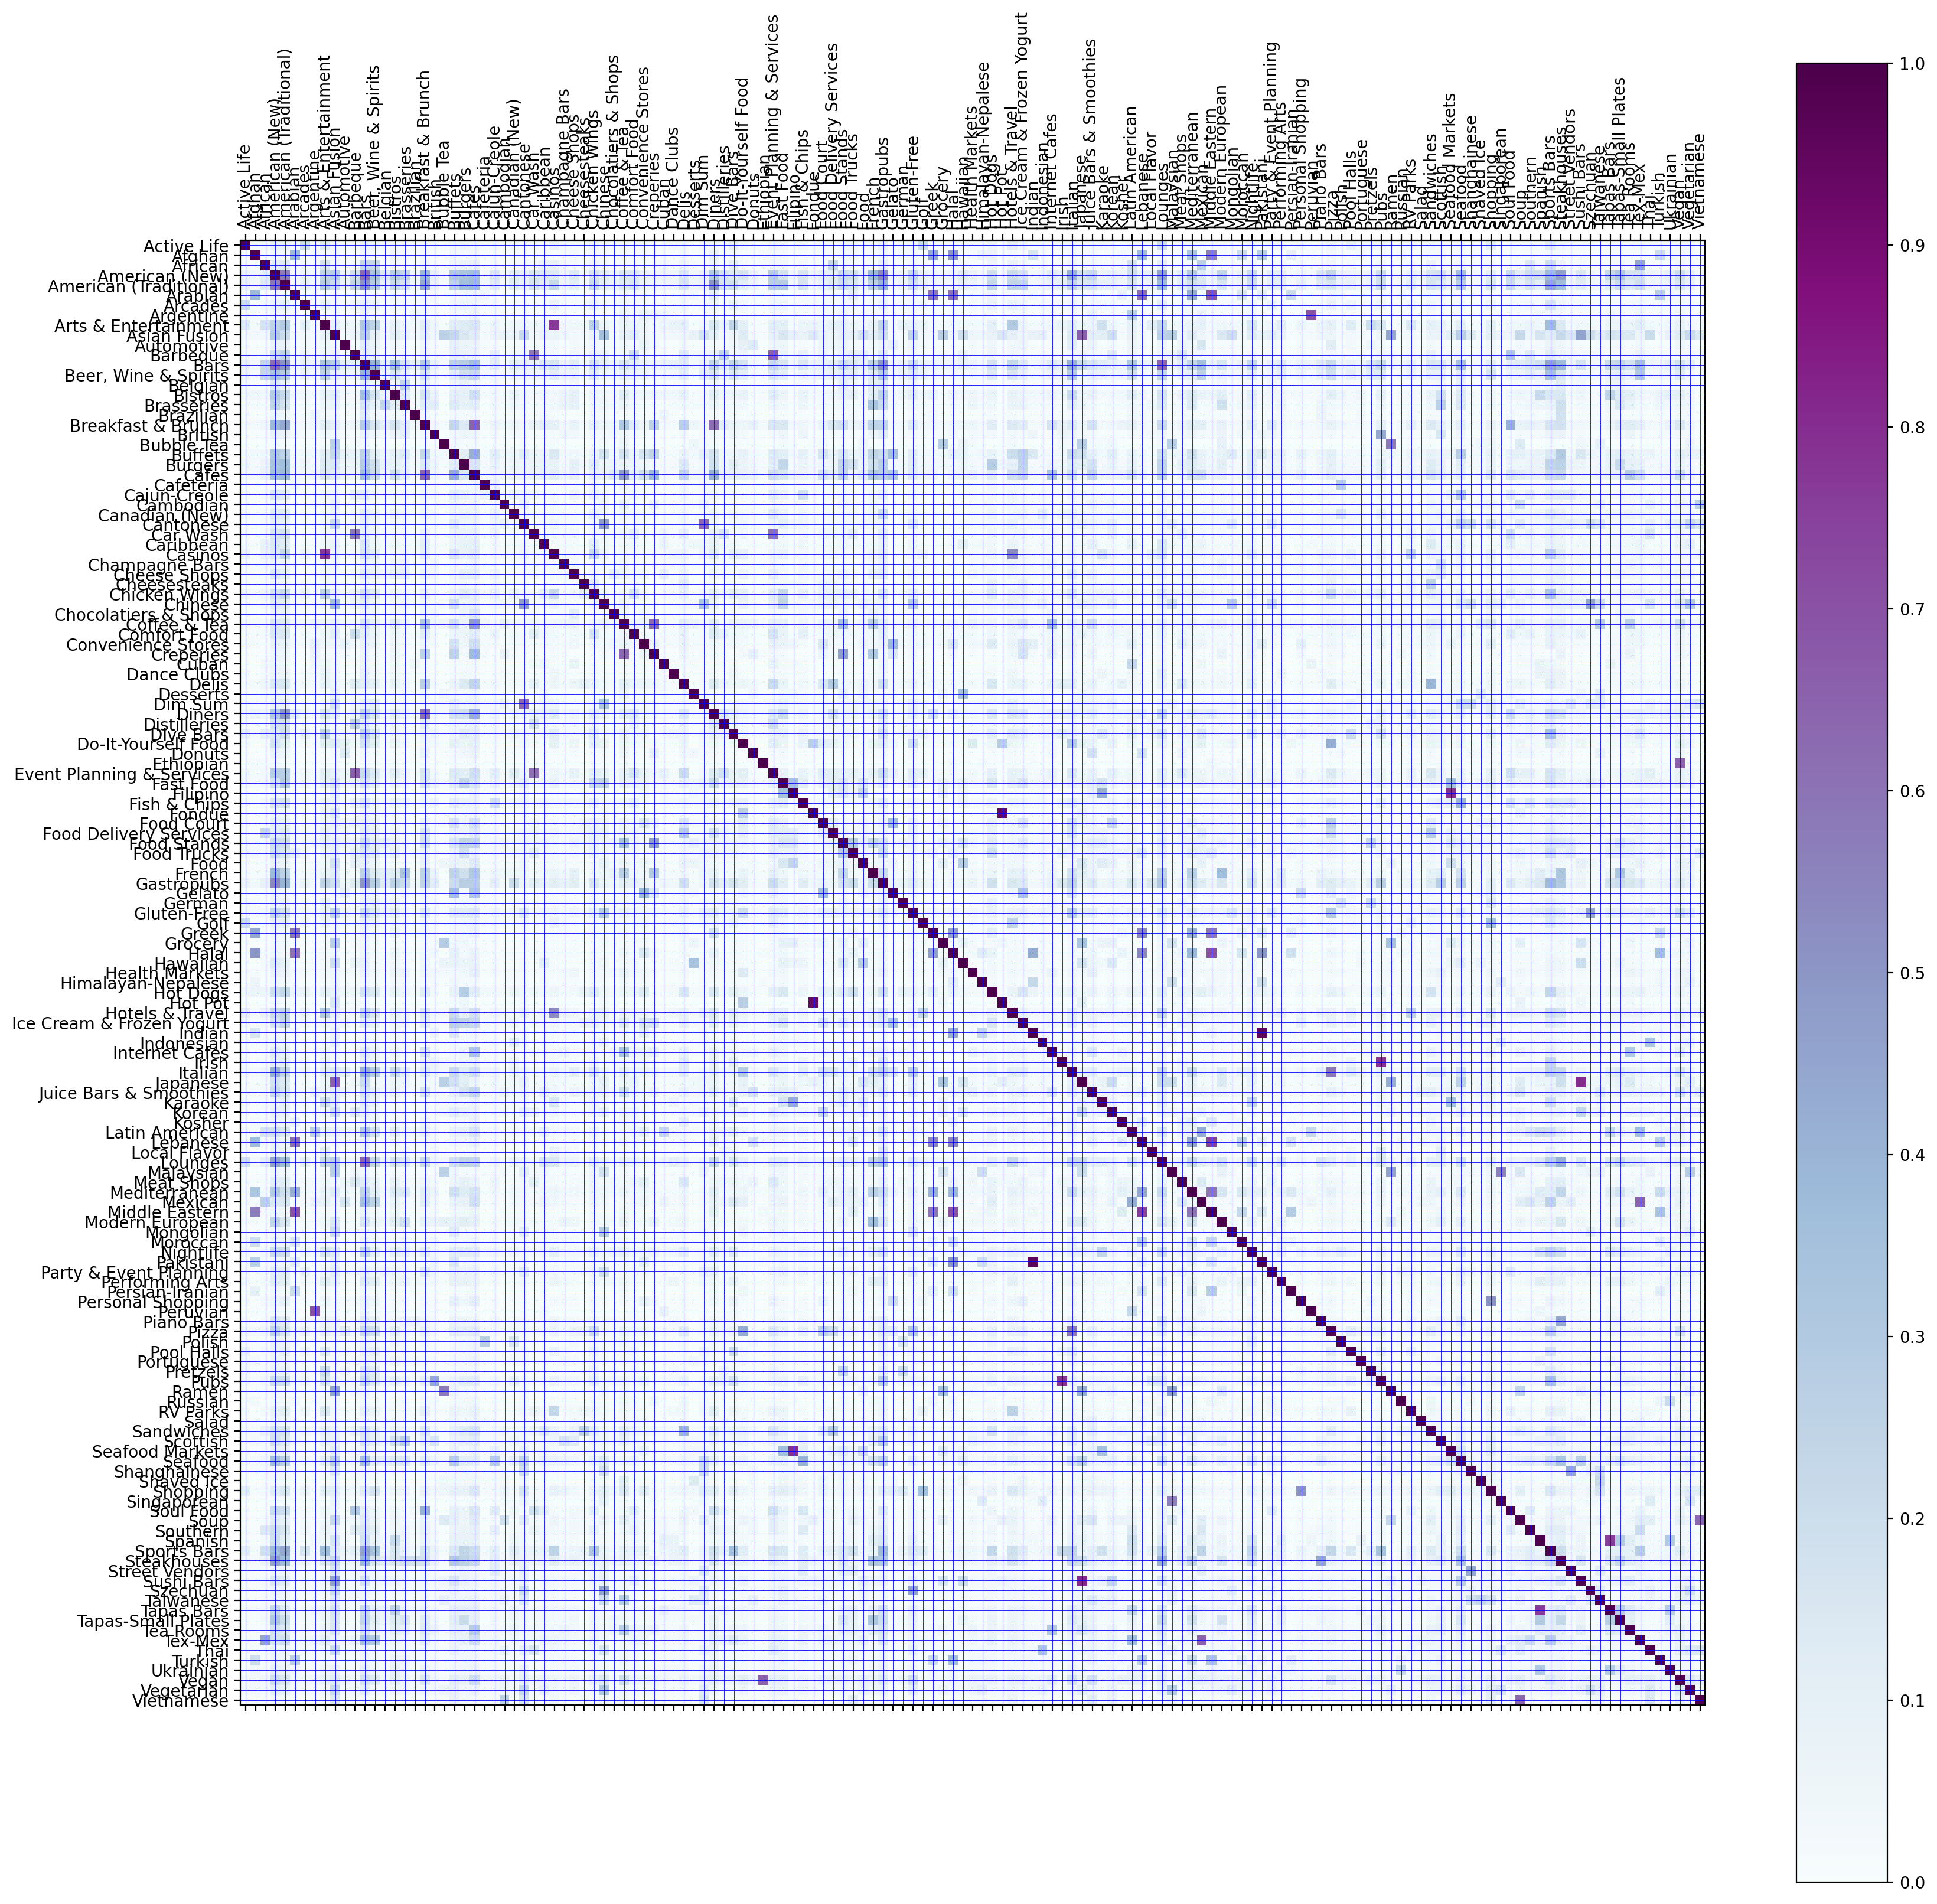

In [100]:
matrix = pd.DataFrame(similarity_if1)
matrix.columns = cuisines
matrix.index = cuisines
draw(matrix)

In [101]:
##########################################################################################################################

In [102]:
%%time
# matrix_if, similarity_if, id2words = vectorizer(contents, use_idf=False)
vectorizer = TfidfVectorizer(stop_words=STOP_WORDS, # from nltk
                             encoding='utf-8',
                             strip_accents='unicode',
                             lowercase=True,
                             use_idf=True,
                             max_features=10000,
                             min_df=0.2, max_df=0.7)
matrix = vectorizer.fit_transform(contents)

CPU times: total: 2min 19s
Wall time: 2min 25s


In [103]:
%%time

# Create id2words mapping
id2words = {}
for i, word in enumerate(vectorizer.get_feature_names_out()):
    id2words[i] = word

# include LDA
corpus = matutils.Sparse2Corpus(matrix, documents_columns=False)
lda = models.ldamodel.LdaModel(corpus, 
                                num_topics=50,
                                id2word=id2words,
                                alpha='auto',
                                eval_every=5) 
doc_topics = lda.get_document_topics(corpus)

# Initialize topic_pro matrix
topic_pro = np.zeros((len(cuisines), 50))  # assuming you want 50 topics
idx = 0

# Loop through doc_topics and fill in topic_pro matrix
for val in doc_topics:
    for jdx, pro in val:
        topic_pro[idx][jdx] = pro
    idx += 1

# Print shape of topic_pro to debug the dimensions
print("Shape of topic_pro:", topic_pro.shape)


Shape of topic_pro: (147, 50)
CPU times: total: 7.97 s
Wall time: 16 s


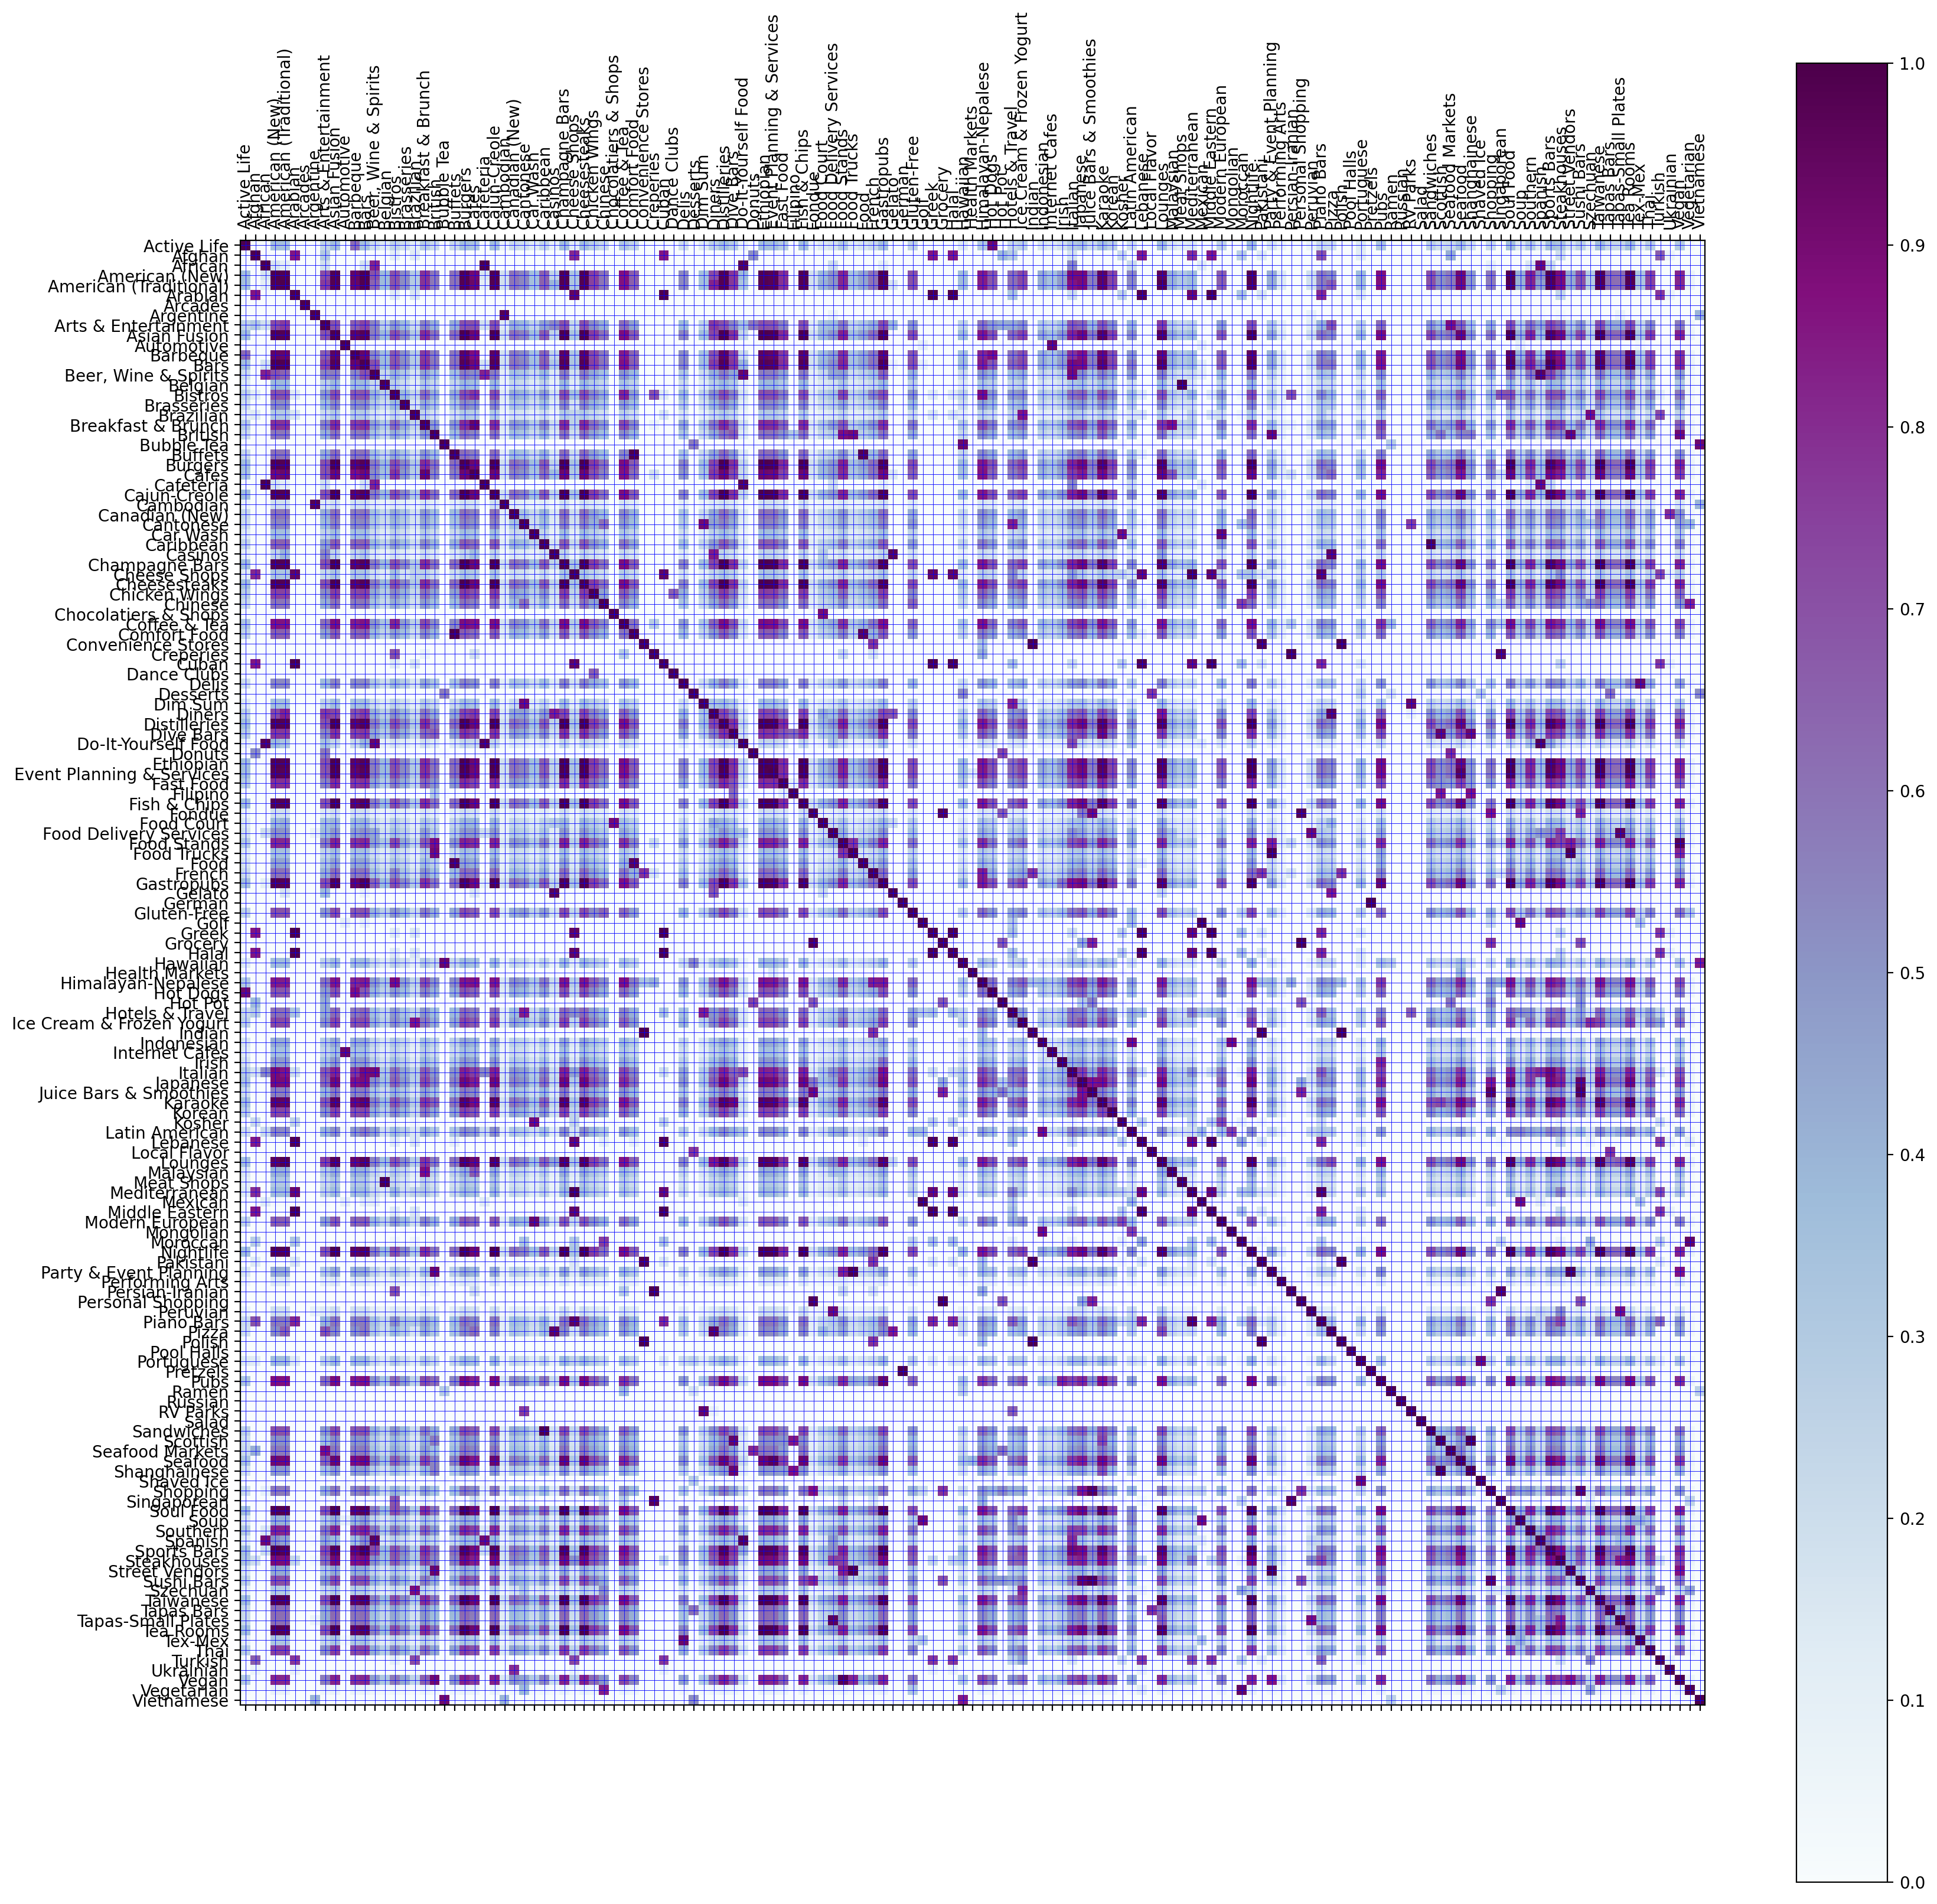

In [104]:
%matplotlib inline
matrix = pd.DataFrame(np.vstack([cosine_similarity(val.reshape(1, -1), topic_pro) for val in topic_pro]))
matrix.columns = cuisines
matrix.index = cuisines
draw(matrix)

In [105]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer

start_time = time.time()

# Instantiate TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True, min_df=2, max_df=0.5)

# Fit and transform your data
matrix_if2 = vectorizer.fit_transform(contents)

# Access feature names
id2words2 = vectorizer.get_feature_names_out()

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")



Execution time: 71.56008505821228 seconds


In [106]:
# %%time
# corpus = matutils.Sparse2Corpus(matrix_if2, documents_columns=False)
# lda = models.ldamodel.LdaModel(corpus, 
#                                 num_topics=100,
#                                 id2word=id2words2,
#                                 alpha='auto',
#                                 eval_every=5)
# doc_topics = lda.get_document_topics(corpus)

In [107]:
cuisine_matrix = [] #similarity of topics
# computing cosine similarity matrix
for i, doc_a in enumerate(doc_topics):
    #print (i)
    sim_vecs = []
    for j , doc_b in enumerate(doc_topics):
        w_sum = 0
        if ( i <= j ):
            norm_a = 0
            norm_b = 0

            for (my_topic_b, weight_b) in doc_b:
                norm_b = norm_b + weight_b*weight_b

            for (my_topic_a, weight_a) in doc_a:
                norm_a = norm_a + weight_a*weight_a
                for (my_topic_b, weight_b) in doc_b:
                    if ( my_topic_a == my_topic_b ):
                        w_sum = w_sum + weight_a*weight_b

            norm_a = math.sqrt(norm_a)
            norm_b = math.sqrt(norm_b)
            denom = (float) (norm_a * norm_b)
            if denom < 0.0001:
                w_sum = 0
            else:
                w_sum = w_sum/(denom)
        else:
            w_sum = cuisine_matrix[j][i]
        sim_vecs.append(w_sum)

    cuisine_matrix.append(sim_vecs)

In [ ]:
%matplotlib inline
matrix = pd.DataFrame(cuisine_matrix)
matrix.columns = cuisines
matrix.index = cuisines
draw(matrix)